In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import svd , eig, inv

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, confusion_matrix

from sklearn.naive_bayes import MultinomialNB

In [2]:
#files on disk
scores_file = 'full_dataset.csv'
vector_file_raw = 'X_raw.npy'
vector_file_clean = 'X_cleaned.npy'
vector_file_i = 'X_with_i.npy'

#load files
df = pd.read_csv(scores_file, index_col=0)

X_raw = np.load(vector_file_raw)
X_clean = np.load(vector_file_clean)
X_i = np.load(vector_file_i)

N = np.shape(X_raw)[0]

y = df['PHQ8_Binary'].values

In [3]:
print(X_raw.shape)
print(X_i.shape)

(189, 8369)
(189, 7863)


Pre-processing the data has taken out about 700 words. Now let's do some EDA on the full dataset.

### EDA

Text(0.5, 1.0, 'Gender Distribution of DAIC-WOZ Dataset')

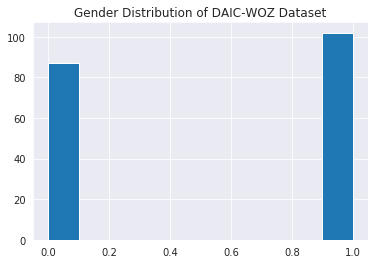

In [4]:
plt.hist(df['Gender'])
plt.title('Gender Distribution of DAIC-WOZ Dataset')

#plt.savefig('distribution_gender.pdf', format='pdf', bbox_inches='tight')
#plt.show()

Text(0.5, 1.0, 'Binary PHQ8 Distribution Scores')

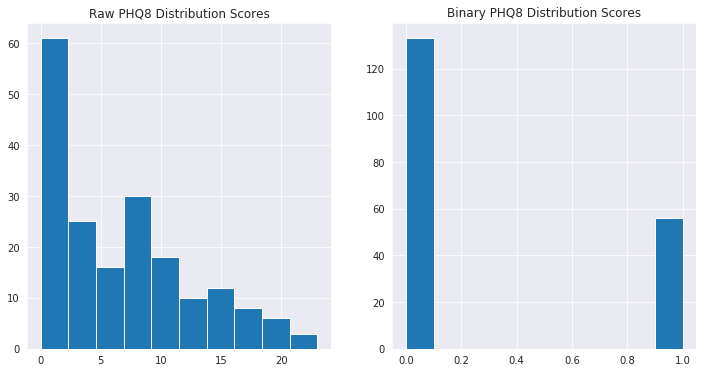

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(df['PHQ8_Score'])
ax[0].set_title('Raw PHQ8 Distribution Scores')

ax[1].hist(df['PHQ8_Binary'])
ax[1].set_title('Binary PHQ8 Distribution Scores')

#plt.savefig('distribution_phq8.pdf', format='pdf', bbox_inches='tight')
#plt.show()

In [6]:
print(np.sum(df['PHQ8_Binary']==0))
print(np.sum(df['PHQ8_Binary']==1))

133
56


Our gender distribution is slightly skewed, but we are more interested in PHQ8 scores. As we can see, the DAIC_WOZ dataset is heavily skewed towards those who score lower on the PHQ8 scale. This could be due to how the binary scores were calculated, although it does seem from the plot on the left of the raw scores that most participants score lower on the PHQ8 scale. This almost 3-1 ratio will need to be taken into account when splitting the data for training. If we are not careful, the splits can miss the "true" distribution of the data, and our models will be biased. In this case, it will be best to use the StratifiedKFold method in scikit-learn when doing cross-validation.

### Training, Classification

Null Hypothesis, H0: preprocessing the text provides no measurable benefit to model training.

Alternative Hypothesis, H1: Preprocessing the text provides a measurable benefit to model training.

For this analysis, we are trying to see if there are words in either the raw or processed datasets that are indicative of a 0 or 1 score on the PHQ8 binary scale.

In [7]:
"""
classify_and_report() creates lists for accuracy, precision, recall, and fbeta score.
It also creates lists for false positive and true positive rates.
Given a sklearn model, the X and y data sets, it creates stratified k-fold training and test sets.
The model is trained, and then metrics are reported and all lists are returned for further analysis.
"""
def classify_and_report(model, X, y, num):
    
    #for reporting metrics
    accuracy, precision, recall, fbeta = [], [], [], []

    #for roc curve
    fpr, tpr, threshold = [], [], []

    #for confusion matrix
    predictions = []
    ytest = []

    #create splits here
    skf = StratifiedKFold(n_splits=num)
    skf.get_n_splits(X, y)

    #loop over n splits
    for train_idx, test_idx in skf.split(X, y):
        #get subsets of data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
    
        ytest.append(y_test)
    
        #fit and predict on training and test data
        preds = model.fit(X_train, y_train).predict(X_test)
        predictions.append(preds)
    
        #calculate scores and append to lists
        acc = accuracy_score(y_test, preds)
        accuracy.append(acc)
    
        pre = precision_score(y_test, preds)
        precision.append(pre)
    
        rec = recall_score(y_test, preds)
        recall.append(rec)
    
        fb = fbeta_score(y_test, preds, 0.5)
        fbeta.append(fb)
    
        #append false positive rate, true positive rate, and threshold values for roc curve
        fpr_roc, tpr_roc, thresh = roc_curve(y_test, preds)
        fpr.append(fpr_roc)
        tpr.append(tpr_roc)
        threshold.append(thresh)
        
        
    report_metrics_binary(accuracy, precision, recall, fbeta)
        
    return accuracy, precision, recall, fbeta, fpr, tpr, ytest, predictions

In [8]:
"""
This helper method takes in lists of accuracy, precision, recall, and fbeta score.
It then outputs the mean score for each list.
"""
def report_metrics_binary(acc, pre, rec, fb):
    #calculate means of scores for reporting
    mean_accuracy = np.round(np.mean(acc), 4)
    mean_precision = np.round(np.mean(pre), 4)
    mean_recall = np.round(np.mean(rec), 4)
    mean_fbeta = np.round(np.mean(fb), 4)
    
    print('Mean accuracy score: ', mean_accuracy)
    print('Mean precision score: ', mean_precision)
    print('Mean recall score: ', mean_recall)
    print('Mean fbeta score: ', mean_fbeta)

We have already decided to use either the Fbeta score or recall for our purposes. This decision was  made based on trying to reduce our Type 2 errors, where someone identifies as being depressed or scores high on the PHQ8 scale, yet our model misclassifies them. When weighing the other metrics, we think Type 1 errors are more permissable.

In [9]:
"""
Plot accuracy, precision, recall, and fbeta score across k-splits to see how they vary.
"""
def plot_metrics_binary(acc, pre, rec, fb):
    plt.plot(accuracy, label='acc', color='r')

    plt.plot(precision, label='prec', color='g')

    plt.plot(recall, label='rec', color='b')

    plt.plot(fbeta, label='fb', color='purple')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('How Metrics Vary Across Stratified Splits')
    plt.show()

In [10]:
"""
Plot the ROC curve, needs false positive and true positive rate arrays as input.
"""
def plot_roc(fpr, tpr):
    #roc curve
    plt.plot([0, 1], [0, 1], 'k--')

    for i, x in enumerate(fpr):
        plt.plot(fpr[i], tpr[i])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

    plt.show()

In [11]:
"""
This method returns the confusion matrix for a given test case.
"""
def plot_cm(ytest, preds, idx):
    cm = confusion_matrix(ytest[idx], preds[idx])
    heatmap = sns.heatmap(cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='right', fontsize=12)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix for Case {}'.format(idx))
    plt.show()

In [30]:
#10-fold split
num = 10

#define model
nbayes = MultinomialNB()

In [31]:
accuracy, precision, recall, fbeta, fpr, tpr, ytest, preds = classify_and_report(nbayes, X_raw, y, num)

Mean accuracy score:  0.7092
Mean precision score:  0.3667
Mean recall score:  0.1067
Mean fbeta score:  0.2353


/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jakidxav/anaconda3/lib/python3.6/site-pack

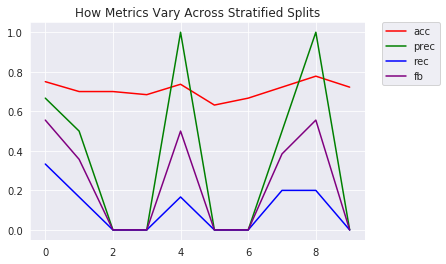

In [32]:
plot_metrics_binary(accuracy, precision, recall, fbeta)

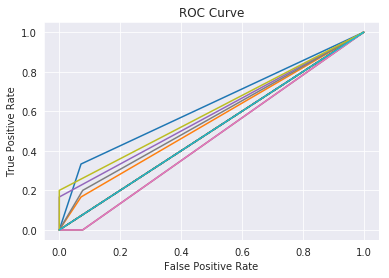

In [33]:
plot_roc(fpr, tpr)

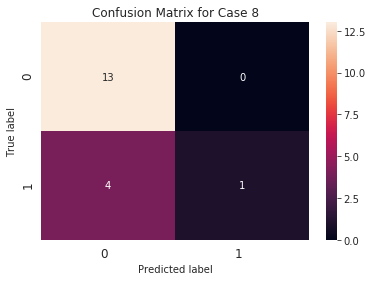

In [34]:
#lets look at the eight split
plot_cm(ytest, preds, 8)

### Now for the processed dataset

Let's see how results change when we used processed data, keeping pronouns and a few other specific words.

In [35]:
accuracy, precision, recall, fbeta, fpr, tpr, ytest, preds = classify_and_report(nbayes, X_i, y, num)

Mean accuracy score:  0.7039
Mean precision score:  0.3333
Mean recall score:  0.1067
Mean fbeta score:  0.2289


/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jakidxav/anaconda3/lib/python3.6/site-pack

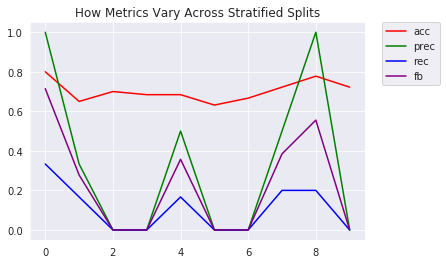

In [36]:
plot_metrics_binary(accuracy, precision, recall, fbeta)

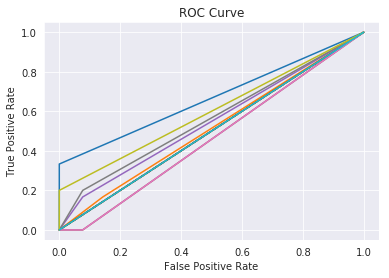

In [37]:
plot_roc(fpr, tpr)

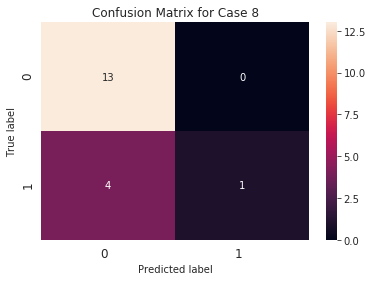

In [38]:
plot_cm(ytest, preds, 8)

The model is not learning at all. There are most likely far too many features for the model to learn well, and the feature matrix is too sparse. As you can see from the confusion matrices, the model is basically always predicting a binary score of 0.

Next steps:
- try different word embeddings (doc2vec, GloVe)
- reduce the feature set

### Principal Components Analysis

In [39]:
#create covariance matrix
C = np.matmul(X_raw, X_raw.T) / N

In [40]:
#eigen alysis on the covariance matrix gives us the EOFs as columns
eigvals, eigvectors = eig(C)

#compute total variance explained by the eigen values
total_eig = np.sum(eigvals)
total_var = eigvals / total_eig

#calculate confidence limits with North et al criterion
delta = total_var * np.sqrt(2 / (N-1))

In [41]:
#amount of variance explained by the first 5 eofs
print([np.round(float(var), 6) for var in total_var[:5]])

[0.774392, 0.048, 0.029593, 0.028736, 0.015344]


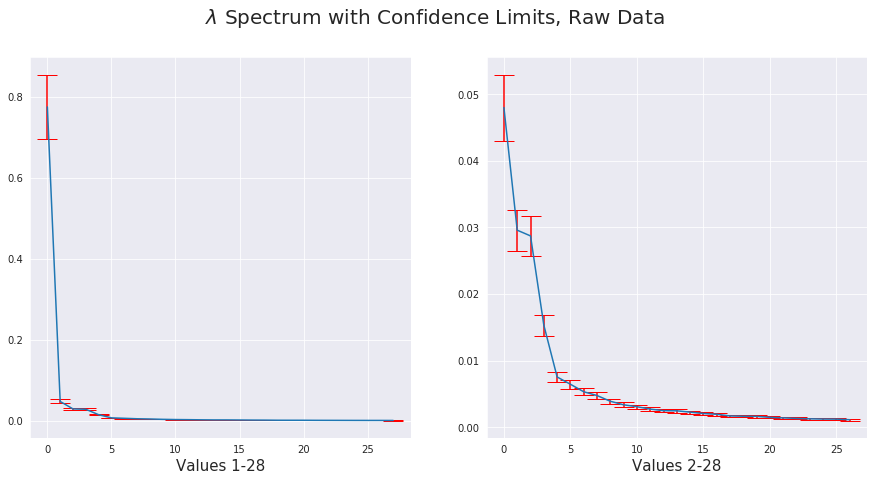

In [42]:
figure, axis = plt.subplots(1, 2, figsize=(15, 7))
axis[0].errorbar(np.arange(0, 28), total_var[:28], yerr=delta[:28], ecolor='r', capsize=10)
axis[1].errorbar(np.arange(0, 27), total_var[1:28], yerr=delta[1:28], ecolor='r', capsize=10)
axis[0].set_title('')
axis[1].set_title('')

figure.suptitle('$\lambda$ Spectrum with Confidence Limits, Raw Data', fontsize=20)
axis[0].set_xlabel('Values 1-28', fontsize=15)
axis[1].set_xlabel('Values 2-28', fontsize=15)

plt.show()

We see  that the first, second, and fifth EOFs are independent, but EOF 3 and 4 explain the same amount of variance. We should use just the first two EOFs for a total of more than 80% explained variance. This would allow us to reduce the sample size from greater than 8000 to just 2.

In [43]:
#check the shape of our EOFs
#should have shape (189, )
print(len(eigvectors[:, 0]))
print(len(eigvectors[:, 1]))

189
189


In [44]:
X_eof = eigvectors[:, :2]

In [45]:
accuracy, precision, recall, fbeta, fpr, tpr, ytest, preds = classify_and_report(nbayes, X_i, y, num)

Mean accuracy score:  0.7039
Mean precision score:  0.3333
Mean recall score:  0.1067
Mean fbeta score:  0.2289


/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jakidxav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jakidxav/anaconda3/lib/python3.6/site-pack

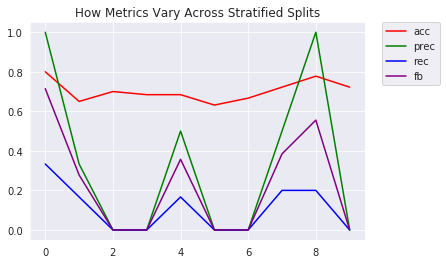

In [46]:
plot_metrics_binary(accuracy, precision, recall, fbeta)

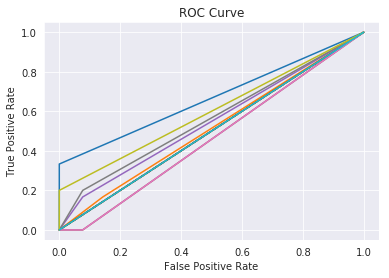

In [47]:
plot_roc(fpr, tpr)

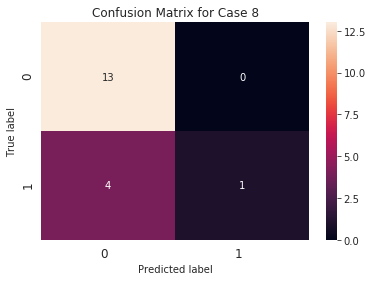

In [48]:
plot_cm(ytest, preds, 8)

It seems that EOF Analysis has no effect on improving performance in this case.